In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, make_scorer
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import joblib
from sklearn.inspection import permutation_importance



              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  

Data types:
ID        object
M/F       object
Hand      object
Age        int64
Educ     float64
SES      float64
MMSE     float64
CDR      float64
eTIV       int64
nWBV     float64
ASF      float64
Delay    float64
dtype: object

Number of missing values in CDR column:
201

Number of missing values in SES column (after dropping NaN CDR Values):
19

Male/Female Proportion Split
M/F
F    66.382979
M    33.617021
Name: proportion, dtype: float64

Mean and Std of Age
Mean: 7

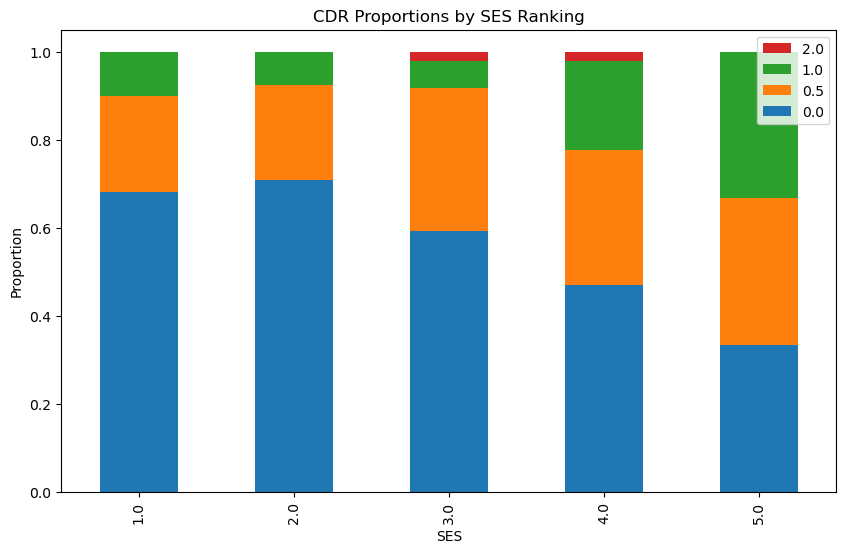


Age against SES


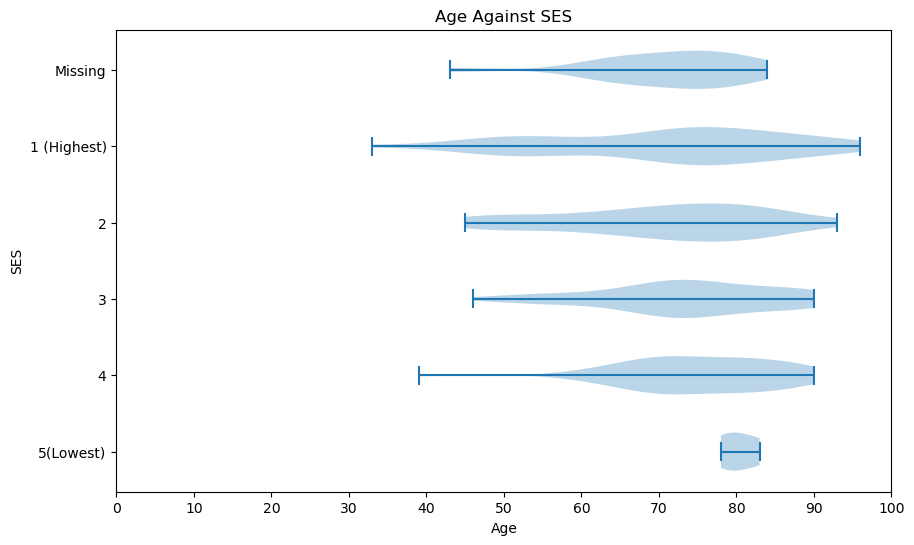


Age against CDR


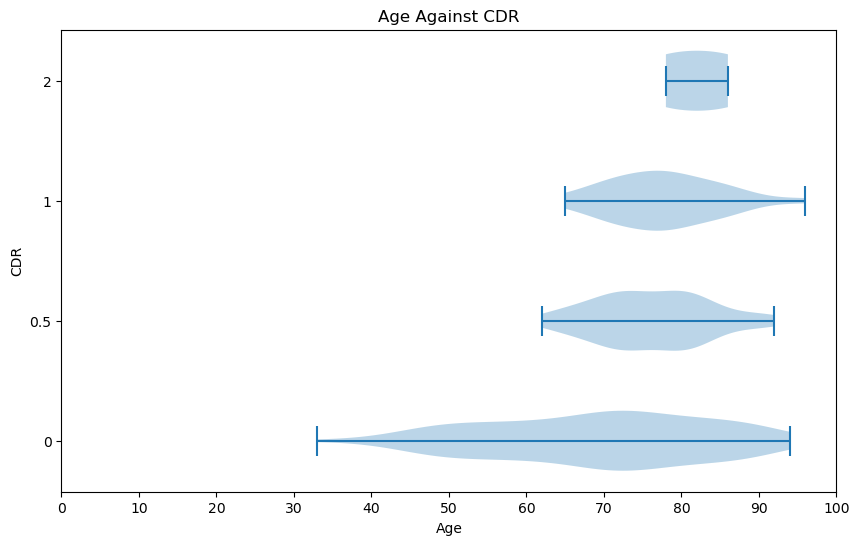

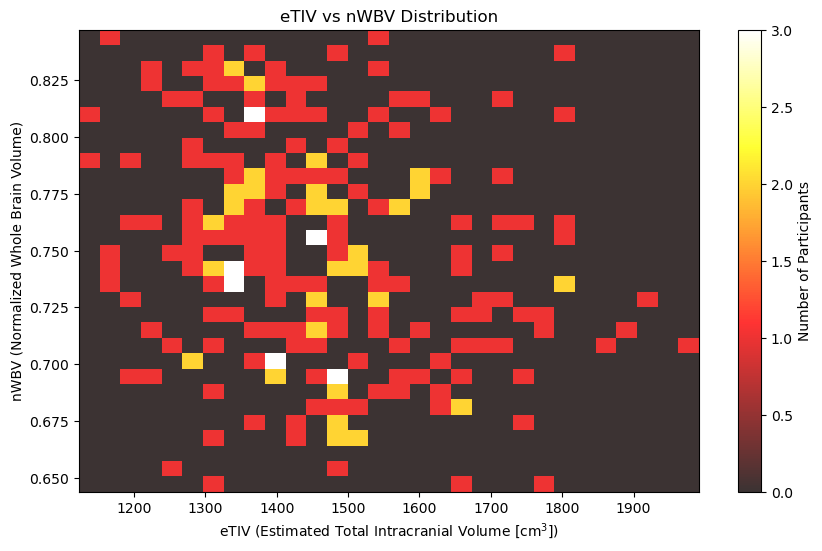

In [2]:
#EDA

#read-in data
df = pd.read_excel('../data/oasis_original.xlsx')

#check df
print(df.head())
print("\nData types:")
print(df.dtypes)
x_nodelay = df.drop(['Delay'], axis=1)

#count number of missing values in CDR column
print("\nNumber of missing values in CDR column:")
print(x_nodelay['CDR'].isnull().sum())

#remove rows with NAN CDR (target variable) values
x_nodelay = x_nodelay.dropna(subset=['CDR'])

#input ? for any empty values in SES column
x_nodelay['SES'] = x_nodelay['SES'].replace('?', np.nan)
print("\nNumber of missing values in SES column (after dropping NaN CDR Values):")
print(x_nodelay['SES'].isnull().sum())


#separate features and target variable
x_clean = x_nodelay.drop(['CDR', 'ID', 'Hand'], axis=1)
y = x_nodelay['CDR']
y_discrete = y.astype(str)

#summary stats
#Sex Percentages
mfpercent = x_clean['M/F'].value_counts(normalize=True) * 100
print("\nMale/Female Proportion Split")
print(mfpercent)
#Age Mean and Std
agemean = x_clean['Age'].mean()
agestd = x_clean['Age'].std()
print("\nMean and Std of Age")
print("Mean: " + str(agemean))
print("STD: " + str(agestd))

#Education percentages
educpercent = x_clean['Educ'].value_counts(normalize=True) * 100
print("\nEducation Proportion Split")
print(educpercent)

#SES percentages
sespercent = x_clean['SES'].value_counts(normalize=True) * 100
print("\nSES Proportion Split")
print(sespercent)

#CDR percentages
cdrpercent = y.value_counts(normalize=True) * 100
print("\nCDR Proportion Split")
print(cdrpercent)

#MMSE Mean and Std
mmsemean = x_clean['MMSE'].mean()
mmsestd = x_clean['MMSE'].std()
print("\nMean and Std of MMSE")
print("Mean: " + str(mmsemean))
print("STD: " + str(mmsestd))

#eTIV Mean and Std
etmean = x_clean['eTIV'].mean()
etstd = x_clean['eTIV'].std()
print("\nMean and Std of eTIV")
print("Mean: " + str(etmean))
print("STD: " + str(etstd))

#nWBV Mean and Std
nmean = x_clean['nWBV'].mean()
nstd = x_clean['nWBV'].std()
print("\nMean and Std of nWBV")
print("Mean: " + str(nmean))
print("STD: " + str(nstd))

#ASF Mean and Std
asfmean = x_clean['ASF'].mean()
asfstd = x_clean['ASF'].std()
print("\nMean and Std of ASF")
print("Mean: " + str(asfmean))
print("STD: " + str(asfstd))

#Plotting figures to visualize data
#Plot SES against CDR
count_matrix = df.groupby(['SES', 'CDR']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis = 0)
print("\nCDR by SES")
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(10,6))
plt.ylabel('Proportion')
#Flip the legend so it matches the graph better
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc=0)
plt.title("CDR Proportions by SES Ranking")
fname_ses_cdr = "../figs/cdr_proportions_by_ses_ranking.png"
plt.savefig(fname_ses_cdr, dpi=300)
plt.show()


        
#Plot Age against SES
print("\nAge against SES")
dataset = [x_clean[x_clean['SES']==5]['Age'].values,
x_clean[x_clean['SES']==4]['Age'].values,
x_clean[x_clean['SES']==3]['Age'].values,
x_clean[x_clean['SES']==2]['Age'].values,
x_clean[x_clean['SES']==1]['Age'].values,
x_clean[x_clean['SES'].isnull()]['Age'].values]

ses_labels = ['5(Lowest)', '4', '3', '2', '1 (Highest)', 'Missing']
ses_positions = range(1, len(ses_labels) + 1)

plt.figure(figsize=(10,6))
plt.violinplot(dataset = dataset, vert= False)
plt.yticks(ses_positions, ses_labels)
plt.xticks(range(0,101,10))
plt.ylabel('SES')
plt.xlabel('Age')
plt.title('Age Against SES')
fname_age_ses = "../figs/age_against_ses.png"
plt.savefig(fname_age_ses, dpi=300)
plt.show()

#Plot Age against CDR
print("\nAge against CDR")
dataset = [df[df['CDR']==0]['Age'].values,
df[df['CDR']==0.5]['Age'].values,
df[df['CDR']==1]['Age'].values,
df[df['CDR']==2]['Age'].values]

plt.figure(figsize=(10,6))
plt.violinplot(dataset = dataset, vert= False)
plt.xticks(range(0,101,10))
plt.ylabel('CDR')
plt.xlabel('Age')
plt.yticks([1, 2, 3, 4], ['0', '0.5', '1', '2'])
plt.title('Age Against CDR')
fname_age_cdr = "../figs/age_against_cdr.png"
plt.savefig(fname_age_cdr, dpi=300)
plt.show()

# Heatmap with eTIV against nWBV
plt.figure(figsize=(10, 6))
plt.hist2d(x_clean['eTIV'], x_clean['nWBV'], bins=30, cmap='hot', alpha=0.8)
plt.colorbar(label='Number of Participants')
plt.xlabel(r'eTIV (Estimated Total Intracranial Volume [cm$^3$])')
plt.ylabel('nWBV (Normalized Whole Brain Volume)')
plt.title('eTIV vs nWBV Distribution')
fname_etiv_nwbv = "../figs/etiv_vs_nwbv_distribution.png"
plt.savefig(fname_etiv_nwbv, dpi=300)
plt.show()



In [3]:
#Feature group types
categorical= ["M/F"]
continuous= ["Age", "MMSE", "eTIV", "nWBV", "ASF"]
ordinal= ["SES", "Educ"]
ordinal_values = [['1.0', '2.0', '3.0', '4.0', '5.0', 'nan'], ['1.0', '2.0', '3.0', '4.0', '5.0']]

for col in ordinal:
    x_clean[col] = x_clean[col].astype(str)

y_discrete_clean = pd.to_numeric(y_discrete, errors='coerce')
cdr_to_class = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}
y_discrete_clean = y_discrete_clean.map(cdr_to_class).astype(int)




In [4]:

random_states = [42, 7, 21, 84, 100]
all_results = []
directory = "../results"

#prep entropy calulation
#note, used Gemini to figure out the best option for measuring the uncertainity of a multiclass problem, but needed to adjust method for looping random states (https://gemini.google.com/share/06da9897a114)
def calculate_entropy_from_probas(probas):
    probas = np.clip(probas, 1e-10, 1)
    entropy_per_sample = -np.sum(probas * np.log2(probas), axis=1)
    return np.mean(entropy_per_sample)

for r in random_states:
    X_train, X_test, y_train, y_test = train_test_split(x_clean, y_discrete_clean, test_size=0.2, random_state=r, shuffle=True, stratify=y_discrete_clean)
    continuous_transformer = [('scaler', StandardScaler())]
    categorical_transformer = [('onehot', OneHotEncoder(handle_unknown='ignore'))]
    ordinal_encoder = [('ordinal', OrdinalEncoder(categories=ordinal_values, dtype=int))]

    #create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cont', StandardScaler(), continuous),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
            ('ord', OrdinalEncoder(categories=ordinal_values, dtype=int), ordinal)],
            remainder='drop'
            )    

    #define pipeline for each model
    #logsitic regression with elastic net
    elastic_net_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])

    elastic_net_params = {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__C': np.logspace(-2, 2, 10),
        'classifier__l1_ratio': np.linspace(0.01,.99,10),
        'classifier__tol': [1e-2],
        'classifier__max_iter': [10000000],
        'classifier__class_weight': ['balanced']
    }

    #kNN Pipeline
    knn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]) 

    knn_params = {
        'classifier__n_neighbors': list(range(1,50)),
        'classifier__weights': ['distance', 'uniform']
    }

    #SVC Pipeline
    svc_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42, probability=True))
    ])

    svc_params = {
        'classifier__kernel': ['rbf', 'linear'],
        'classifier__C': np.linspace(0.1, 10, 20)
    }

    #random forest pipeline
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    rf_params = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30],
    }


    scoring_metric = make_scorer(f1_score, average='macro')

   #grid search for elastic net
    elastic_net_grid = GridSearchCV(elastic_net_pipeline, elastic_net_params, cv=2, scoring=scoring_metric, n_jobs=-1)
    grid_search_elastic_net = elastic_net_grid.fit(X_train, y_train)
    
    #grid search for KNN
    knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=2, scoring=scoring_metric, n_jobs=-1)
    grid_search_knn = knn_grid.fit(X_train, y_train)

    #grid search for SVC
    svc_grid = GridSearchCV(svc_pipeline, svc_params, cv=2, scoring=scoring_metric, n_jobs=-1)
    grid_search_svc = svc_grid.fit(X_train, y_train)

    #grid search for RF
    rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=2, scoring=scoring_metric, n_jobs=-1)
    grid_search_rf = rf_grid.fit(X_train, y_train)

    #calculate baseline F1 score by predicting the most frequent class
    most_frequent_class = y_test.mode()[0]
    y_baseline_pred = [most_frequent_class] * len(y_test)
    baseline_f1 = f1_score(y_test, y_baseline_pred, average='macro')

    elas_test_score = grid_search_elastic_net.score(X_test, y_test)
    knn_test_score = grid_search_knn.score(X_test, y_test)
    svc_test_score = grid_search_svc.score(X_test, y_test)
    rf_test_score = grid_search_rf.score(X_test, y_test)

    #caluclate and print entropy for each model
    elas_probas = grid_search_elastic_net.predict_proba(X_test)
    elas_entropy = calculate_entropy_from_probas(elas_probas)
    print(f"Elastic Net Avg. Prediction Entropy: {elas_entropy:.4f}")

    knn_probas = grid_search_knn.predict_proba(X_test)
    knn_entropy = calculate_entropy_from_probas(knn_probas)
    print(f"KNN Avg. Prediction Entropy: {knn_entropy:.4f}")

    svc_probas = grid_search_svc.predict_proba(X_test)
    svc_entropy = calculate_entropy_from_probas(svc_probas)
    print(f"SVC Avg. Prediction Entropy: {svc_entropy:.4f}")

    rf_probas = grid_search_rf.predict_proba(X_test)
    rf_entropy = calculate_entropy_from_probas(rf_probas)
    print(f"RF Avg. Prediction Entropy: {rf_entropy:.4f}")

    #save the best models for this random state
    joblib.dump(grid_search_elastic_net.best_estimator_, 
                os.path.join(directory, f"run_results/best_elastic_net_model_r{r}.pkl"))
                
    joblib.dump(grid_search_knn.best_estimator_, 
                os.path.join(directory, f"run_results/best_knn_model_r{r}.pkl"))
                
    joblib.dump(grid_search_svc.best_estimator_, 
                os.path.join(directory, f"run_results/best_svc_model_r{r}.pkl"))
                
    joblib.dump(grid_search_rf.best_estimator_, 
                os.path.join(directory, f"run_results/best_random_forest_model_r{r}.pkl"))

    current_run_summary = pd.DataFrame({
        'Random State': [r] * 4,
        'Model': ['Elastic Net', 'KNN', 'SVC', 'Random Forest'],
        'Best CV F1 Score': [
            grid_search_elastic_net.best_score_, 
            grid_search_knn.best_score_, 
            grid_search_svc.best_score_, 
            grid_search_rf.best_score_
        ],
        'Final Test F1 Score': [elas_test_score, knn_test_score, svc_test_score, rf_test_score],
        'Avg. Prediction Entropy': [elas_entropy, knn_entropy, svc_entropy, rf_entropy]
    })

    baseline_row = pd.DataFrame({
        'Random State': [r],
        'Model': ['Baseline (Most Frequent)'],
        'Best CV F1 Score': [np.nan],
        'Final Test F1 Score': [baseline_f1]
    })

    current_run_summary = pd.concat([current_run_summary, baseline_row], ignore_index=True)

    all_results.append(current_run_summary)

    print(f"\nResults for Random State {r} collected.")
    print(current_run_summary)

#store all results
final_results_df = pd.concat(all_results, ignore_index=True)
    
final_results_df.to_csv(os.path.join(directory, 'all_model_scores_aggregated.csv'), index=False)

model_results = final_results_df[final_results_df['Model'] != 'Baseline (Most Frequent)'].copy()
best_models_summary = []

for model_name in model_results['Model'].unique():
    
    #filter the DataFrame for the current model
    current_model_df = model_results[model_results['Model'] == model_name]
    
    #find the row with the maximum Final Test F1 Score for this model
    best_run_row = current_model_df.loc[current_model_df['Final Test F1 Score'].idxmax()]
    best_state = int(best_run_row['Random State'])
    best_score = best_run_row['Final Test F1 Score']
    best_cv_score = best_run_row['Best CV F1 Score']
    
    #store the summary
    best_models_summary.append({
        'Model': model_name,
        'Best Test F1 Score': best_score,
        'Random State (Best Run)': best_state,
        'Corresponding CV Score': best_cv_score,
        'Best Model Filename': f"best_{model_name.lower().replace(' ', '_')}_model_r{best_state}.pkl"
    })
best_models_df = pd.DataFrame(best_models_summary)

for index, row in best_models_df.iterrows():
    
    model_name = row['Model']
    best_state = row['Random State (Best Run)']
    
    input_filename = os.path.join(directory, f"run_results/best_{model_name.lower().replace(' ', '_')}_model_r{best_state}.pkl")
    
    output_filename = os.path.join(directory, f"FINAL_{model_name.lower().replace(' ', '_')}_model.pkl")
    
    try:
        best_model_pipeline = joblib.load(input_filename)
        
        joblib.dump(best_model_pipeline, output_filename)
        
        print(f"Exported final best {model_name} model to: {output_filename}")
        
    except FileNotFoundError:
        print(f"Error: Could not find the file {input_filename}.")


Elastic Net Avg. Prediction Entropy: 1.1370
KNN Avg. Prediction Entropy: 0.0000
SVC Avg. Prediction Entropy: 1.0054
RF Avg. Prediction Entropy: 0.9320

Results for Random State 42 collected.
   Random State                     Model  Best CV F1 Score  \
0            42               Elastic Net          0.586983   
1            42                       KNN          0.403701   
2            42                       SVC          0.565519   
3            42             Random Forest          0.434786   
4            42  Baseline (Most Frequent)               NaN   

   Final Test F1 Score  Avg. Prediction Entropy  
0             0.436753             1.137050e+00  
1             0.496914             9.965784e-09  
2             0.685684             1.005359e+00  
3             0.540598             9.320314e-01  
4             0.243243                      NaN  
Elastic Net Avg. Prediction Entropy: 1.1169
KNN Avg. Prediction Entropy: 0.0000
SVC Avg. Prediction Entropy: 0.9516
RF Avg. Predic

In [5]:
#calculate mean and standard deviations of test scores and entropy scores across all ranodm states for each model
mean_std_summary = final_results_df.groupby('Model')[['Final Test F1 Score', 'Avg. Prediction Entropy']].agg(['mean', 'std']).reset_index()
mean_std_summary.columns = ['Model', 'Mean Final Test F1 Score', 'STD of Final Test F1 Score', 'Mean Avg. Prediction Entropy', 'STD of Avg. Prediction Entropy']
print("\nMean and STD of Final Test F1 Scores and Avg. Prediction Entropy across all Random States:")
print(mean_std_summary)
#save to csv
mean_std_summary.to_csv(os.path.join(directory, 'mean_std_final_test_f1_scores.csv'), index=False)


Mean and STD of Final Test F1 Scores and Avg. Prediction Entropy across all Random States:
                      Model  Mean Final Test F1 Score  \
0  Baseline (Most Frequent)                  0.243243   
1               Elastic Net                  0.490851   
2                       KNN                  0.529508   
3             Random Forest                  0.609399   
4                       SVC                  0.566057   

   STD of Final Test F1 Score  Mean Avg. Prediction Entropy  \
0                    0.000000                           NaN   
1                    0.112955                      1.113030   
2                    0.066356                      0.455384   
3                    0.065339                      0.910874   
4                    0.156008                      0.997034   

   STD of Avg. Prediction Entropy  
0                             NaN  
1                        0.075580  
2                        0.419512  
3                        0.081895  
4     

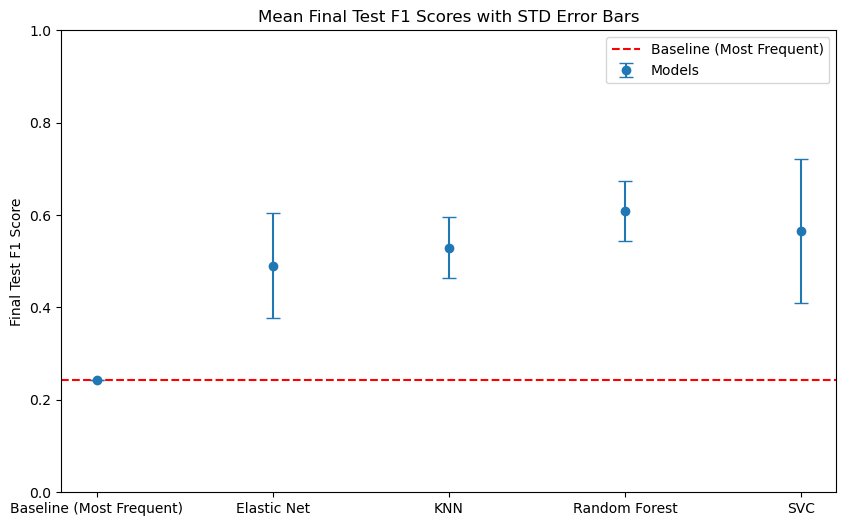

In [6]:

#plot mean and std of final test f1 scores with error bars, with baseline as horizontal line
plt.figure(figsize=(10,6))
plt.errorbar(mean_std_summary['Model'], mean_std_summary['Mean Final Test F1 Score'], 
             yerr=mean_std_summary['STD of Final Test F1 Score'], fmt='o', capsize=5, label='Models')
#add baseline line
baseline_mean = final_results_df[final_results_df['Model'] == 'Baseline (Most Frequent)']['Final Test F1 Score'].mean()
plt.axhline(y=baseline_mean, color='r', linestyle='--', label='Baseline (Most Frequent)')
plt.ylabel('Final Test F1 Score')
plt.title('Mean Final Test F1 Scores with STD Error Bars')
plt.ylim(0, 1)
plt.legend()
fname_mean_std_f1 = os.path.join(directory, '../figs/mean_std_final_test_f1_scores.png')
plt.savefig(fname_mean_std_f1, dpi=300)
plt.show()


In [7]:
#find the best random forest model
rf_best_row = best_models_df[best_models_df['Model'] == 'Random Forest'].iloc[0]
best_rf_state = rf_best_row['Random State (Best Run)']
best_rf_filename = rf_best_row['Best Model Filename']
print(f"\nThe best Random Forest model was trained with Random State: {best_rf_state}")
print(f"The model file to load is: {best_rf_filename}")

directory_best = "../results/run_results/"
#load best random forest mode
best_rf_pipeline = joblib.load(os.path.join(directory_best, best_rf_filename))
#extract best model from pipeline
best_rf_model = best_rf_pipeline.named_steps['classifier']
best_rf_processor = best_rf_pipeline.named_steps['preprocessor']

#find best SVC model
svc_best_row = best_models_df[best_models_df['Model'] == 'SVC'].iloc[0]
best_svc_state = svc_best_row['Random State (Best Run)']
best_svc_filename = svc_best_row['Best Model Filename']
print(f"\nThe best SVC model was trained with Random State: {best_svc_state}")
print(f"The model file to load is: {best_svc_filename}")
#load best SVC model
best_svc_pipeline = joblib.load(os.path.join(directory_best, best_svc_filename))
#extract best model from pipeline
best_svc_model = best_svc_pipeline.named_steps['classifier']
best_svc_processor = best_svc_pipeline.named_steps['preprocessor']

#find best elastic net model
elastic_best_row = best_models_df[best_models_df['Model'] == 'Elastic Net'].iloc[0]
best_elastic_state = elastic_best_row['Random State (Best Run)']
best_elastic_filename = elastic_best_row['Best Model Filename']
print(f"\nThe best Elastic Net model was trained with Random State: {best_elastic_state}")
print(f"The model file to load is: {best_elastic_filename}")
#load best elastic net model
best_elastic_pipeline = joblib.load(os.path.join(directory_best, best_elastic_filename))
#extract best model from pipeline
best_elastic_model = best_elastic_pipeline.named_steps['classifier']
best_elastic_processor = best_elastic_pipeline.named_steps['preprocessor']

#find best KNN model
knn_best_row = best_models_df[best_models_df['Model'] == 'KNN'].iloc[0]
best_knn_state = knn_best_row['Random State (Best Run)']
best_knn_filename = knn_best_row['Best Model Filename']
print(f"\nThe best KNN model was trained with Random State: {best_knn_state}")
print(f"The model file to load is: {best_knn_filename}")
#load best KNN model
best_knn_pipeline = joblib.load(os.path.join(directory_best, best_knn_filename))
#extract best model from pipeline
best_knn_model = best_knn_pipeline.named_steps['classifier']
best_knn_processor = best_knn_pipeline.named_steps['preprocessor']


The best Random Forest model was trained with Random State: 21
The model file to load is: best_random_forest_model_r21.pkl

The best SVC model was trained with Random State: 7
The model file to load is: best_svc_model_r7.pkl

The best Elastic Net model was trained with Random State: 21
The model file to load is: best_elastic_net_model_r21.pkl

The best KNN model was trained with Random State: 21
The model file to load is: best_knn_model_r21.pkl


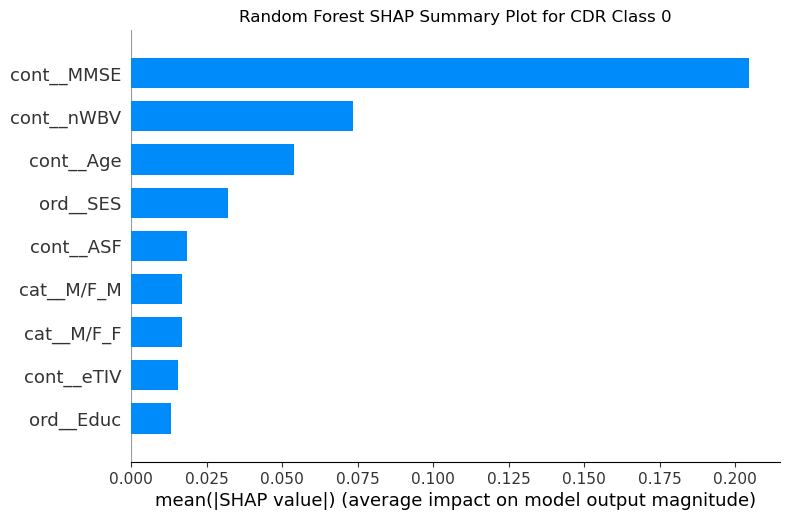

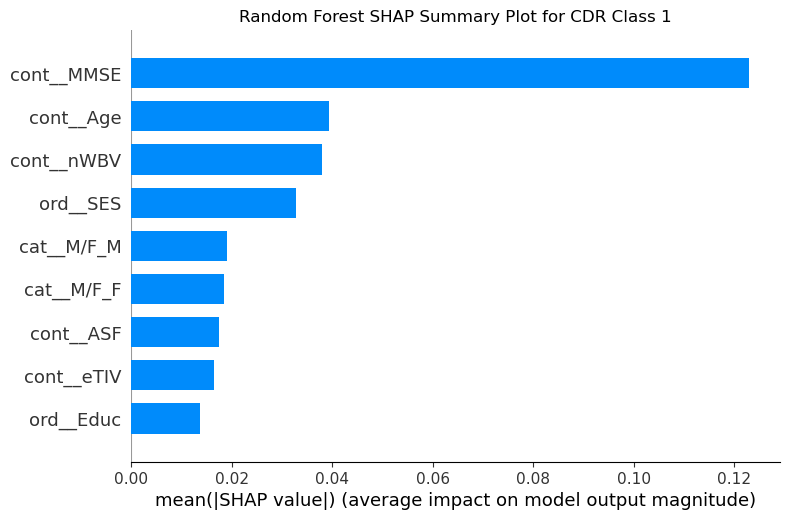

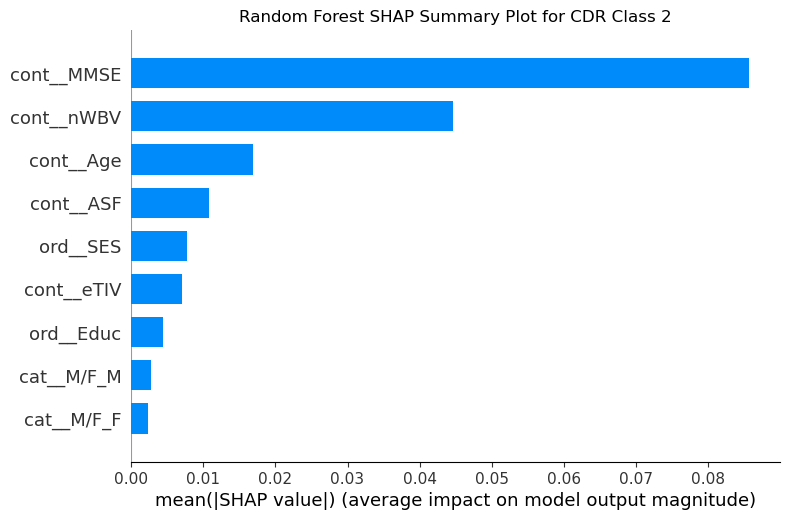

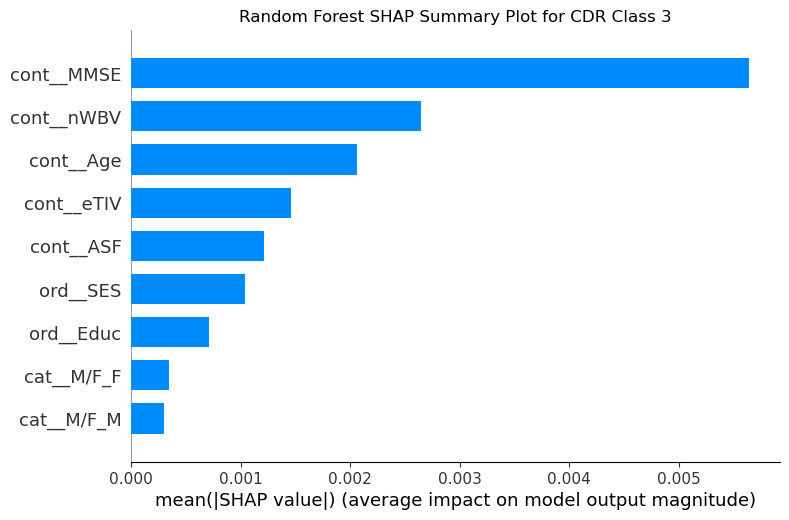

In [8]:
#shap global feature importance for each CDR class
#RF SHAP
#split data with best random state
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(x_clean, y_discrete_clean, test_size=0.2, random_state=best_rf_state, shuffle=True, stratify=y_discrete_clean)  
explainer_rf = shap.Explainer(best_rf_model, best_rf_processor.transform(X_train_best))
X_test_transformed = best_rf_processor.transform(X_test_best)

shap_values_rf = explainer_rf(best_rf_processor.transform(X_test_best))
feature_names = best_rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
X_test_best_named = pd.DataFrame(X_test_transformed, columns=feature_names)

#plot summary plot for each class
for class_index in range(4):
    plt.figure(figsize=(10,8))
    shap.summary_plot(shap_values_rf.values[:, :, class_index], 
                      features=X_test_best_named, 
                      feature_names=feature_names, 
                      plot_type='bar',
                      show=False)
    plt.title(f'Random Forest SHAP Summary Plot for CDR Class {class_index}')
    fname_rf_shap = f"../figs/rf_shap_summary_cdr_class_{class_index}.png"
    plt.savefig(fname_rf_shap, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
#calculate permutation importance for best RF model
#process test data with best processor
X_test_transformed = best_rf_processor.transform(X_test)

result = permutation_importance(best_rf_model, X_test_transformed, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': best_rf_pipeline.named_steps['preprocessor'].get_feature_names_out(),
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
})
perm_importance_df = perm_importance_df.sort_values(by='Importance Mean', ascending=False)
print("\nPermutation Importance for RF Model:")
print(perm_importance_df)

#save output to csv
perm_importance_df.to_csv(os.path.join(directory, 'rf_permutation_importance.csv'), index=False)


Permutation Importance for RF Model:
      Feature  Importance Mean  Importance Std
1  cont__MMSE         0.266667        0.047808
3  cont__nWBV         0.085816        0.038252
0   cont__Age         0.041135        0.021929
7    ord__SES         0.027660        0.018344
4   cont__ASF         0.024823        0.007929
2  cont__eTIV         0.024113        0.011952
8   ord__Educ         0.015603        0.010895
5  cat__M/F_F         0.012057        0.010543
6  cat__M/F_M         0.012057        0.010543


In [10]:
#grab MDI feature importance for best RF model
mdi_importances = best_rf_model.feature_importances_
mdi_importance_df = pd.DataFrame({
    'Feature': best_rf_pipeline.named_steps['preprocessor'].get_feature_names_out(),
    'MDI Importance': mdi_importances
})
mdi_importance_df = mdi_importance_df.sort_values(by='MDI Importance', ascending=False)
print("\nMDI Feature Importance for RF Model:")
print(mdi_importance_df)

#save to csv
mdi_importance_df.to_csv(os.path.join(directory, 'rf_mdi_feature_importance.csv'), index=False)


MDI Feature Importance for RF Model:
      Feature  MDI Importance
1  cont__MMSE        0.335514
3  cont__nWBV        0.165644
0   cont__Age        0.135339
4   cont__ASF        0.101606
2  cont__eTIV        0.095298
7    ord__SES        0.081557
8   ord__Educ        0.051100
6  cat__M/F_M        0.018061
5  cat__M/F_F        0.015881


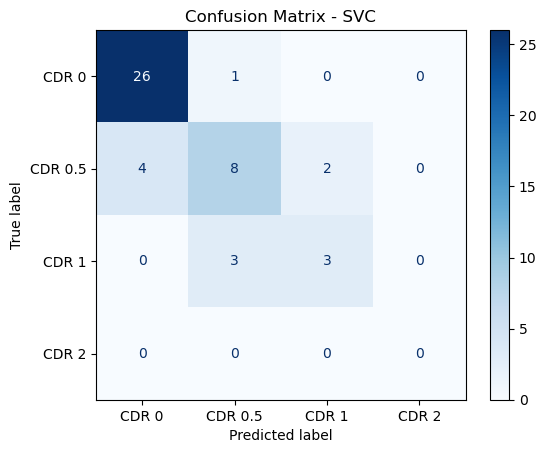

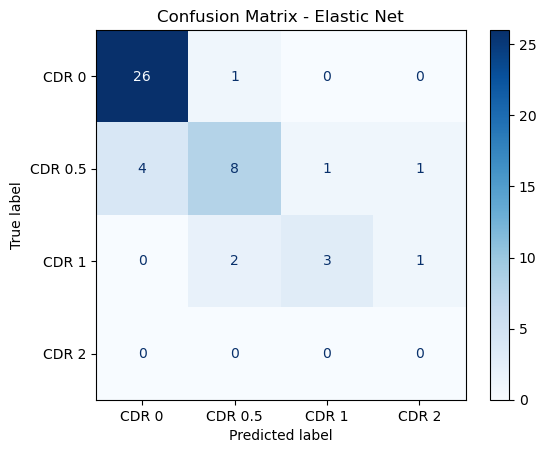

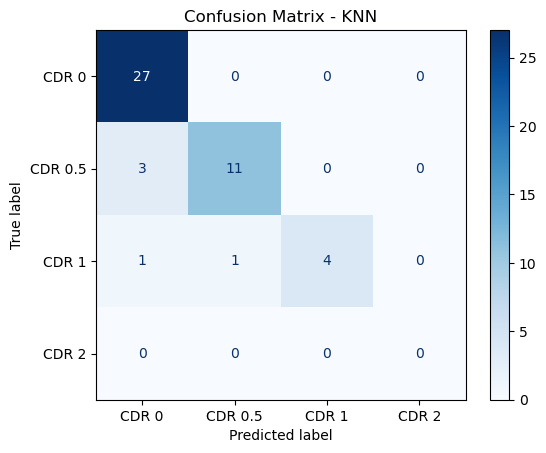

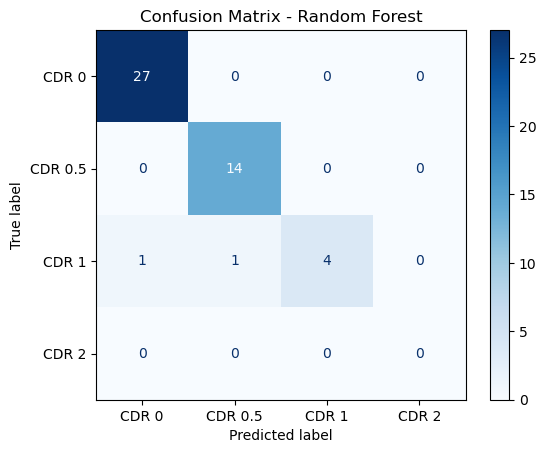

In [11]:
class_conf_labels = [0, 1, 2, 3]

#confusion matrix for SVC
y_svc_test_pred = best_svc_model.predict(best_svc_processor.transform(X_test))

confusion_matrix_svc = confusion_matrix(y_test, y_svc_test_pred, labels=class_conf_labels)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svc, display_labels=['CDR 0', 'CDR 0.5', 'CDR 1', 'CDR 2'])
disp_svc.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVC")
fname_confusion = "../figs/svc_confusion_matrix.png"
plt.savefig(fname_confusion, dpi = 300)
plt.show()

#confusion matrix for Elastic Net
y_elastic_test_pred = best_elastic_model.predict(best_elastic_processor.transform(X_test))
confusion_matrix_elastic = confusion_matrix(y_test, y_elastic_test_pred, labels=class_conf_labels)
disp_elastic = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_elastic, display_labels=['CDR 0', 'CDR 0.5', 'CDR 1', 'CDR 2'])
disp_elastic.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Elastic Net")
fname_confusion = "../figs/elastic_net_confusion_matrix.png"
plt.savefig(fname_confusion, dpi = 300)
plt.show()

#confusion matrix for KNN
y_knn_test_pred = best_knn_model.predict(best_knn_processor.transform(X_test))
confusion_matrix_knn = confusion_matrix(y_test, y_knn_test_pred, labels=class_conf_labels)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn, display_labels=['CDR 0', 'CDR 0.5', 'CDR 1', 'CDR 2'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
fname_confusion = "../figs/knn_confusion_matrix.png"
plt.savefig(fname_confusion, dpi = 300)
plt.show()

#confusion matrix for RF
y_rf_test_pred = best_rf_model.predict(best_rf_processor.transform(X_test))
confusion_matrix_rf = confusion_matrix(y_test, y_rf_test_pred, labels=class_conf_labels)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf, display_labels=['CDR 0', 'CDR 0.5', 'CDR 1', 'CDR 2'])
disp_rf.plot(cmap=plt.cm.Blues) 
plt.title("Confusion Matrix - Random Forest")
fname_confusion = "../figs/rf_confusion_matrix.png"
plt.savefig(fname_confusion, dpi = 300)
plt.show()





Index in Test Set: 13
Actual CDR: 1.0
Predicted CDR: 0.5


<Figure size 2000x2000 with 0 Axes>

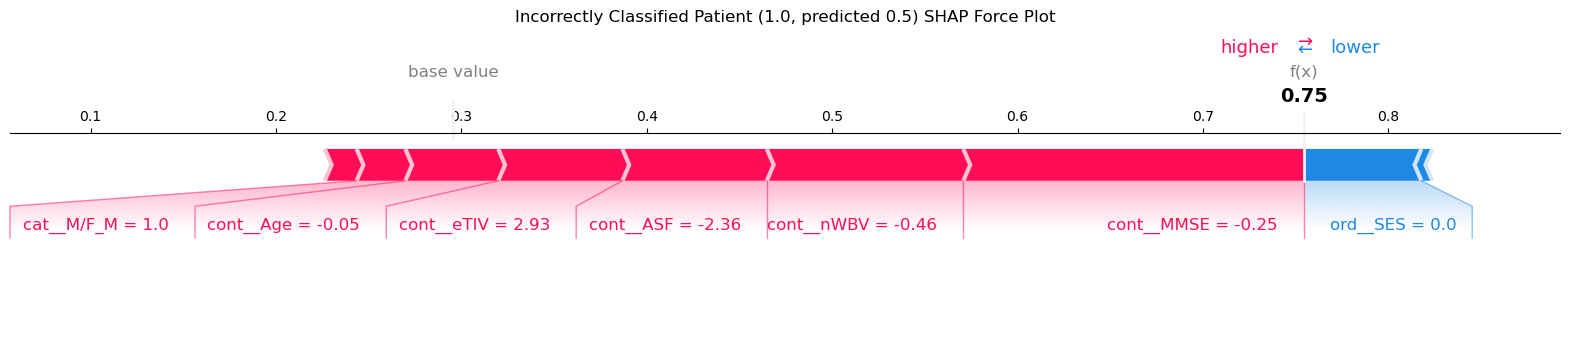

Index in Test Set: 31
Actual CDR: 0.5
Predicted CDR: 0.5


<Figure size 2000x1500 with 0 Axes>

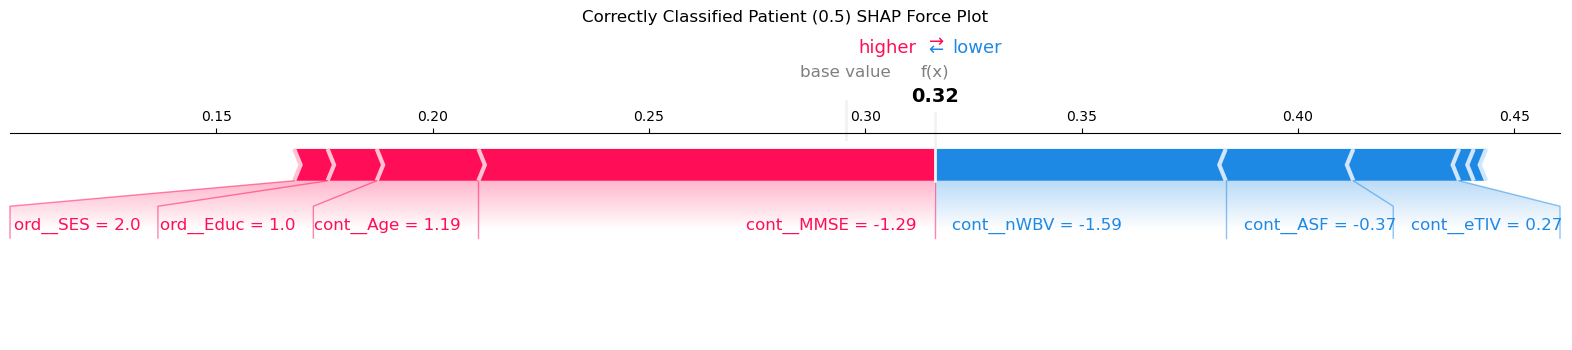

In [12]:
incorrect_patients = (y_test.values != y_rf_test_pred)
incorrect_indices = np.where(incorrect_patients)[0]
patient_index_to_explain_wrong = incorrect_indices[0] 
#get the correct class labels
class_to_cdr = {0: 0.0, 1: 0.5, 2: 1.0, 3: 2.0}
actual_cdr_wrong = class_to_cdr[y_test.iloc[patient_index_to_explain_wrong]]
predicted_cdr_wrong = class_to_cdr[y_rf_test_pred[patient_index_to_explain_wrong]]

print(f"Index in Test Set: {patient_index_to_explain_wrong}")
print(f"Actual CDR: {actual_cdr_wrong}")
print(f"Predicted CDR: {predicted_cdr_wrong}")

predicted_class_wrong = y_rf_test_pred[patient_index_to_explain_wrong]

class_index = int(predicted_class_wrong)

plt.figure(figsize=(20, 20))
shap.force_plot(
    explainer_rf.expected_value[class_index], 
    shap_values_rf.values[patient_index_to_explain_wrong, :, class_index], 
    #rounding feature values for better visualization
    X_test_best_named.iloc[patient_index_to_explain_wrong, :].round(2), 
    feature_names=feature_names, 
    matplotlib=True,
    show = False
)
plt.subplots_adjust(top=0.8)
plt.title(f"Incorrectly Classified Patient ({actual_cdr_wrong}, predicted {predicted_cdr_wrong}) SHAP Force Plot", y=1.5)
fname_incorrect = "../figs/incorrectly_classified_patient_shap_force_plot.png"
plt.savefig(fname_incorrect, dpi=300, bbox_inches='tight')
plt.show()


correct_patients = (y_test.values == 1) & (y_svc_test_pred == 1)
correct_indices = np.where(correct_patients)[0]
patient_index_to_explain_correct = correct_indices[5] 

#get the correct class labels out
actual_cdr_correct = class_to_cdr[y_test.iloc[patient_index_to_explain_correct]]
predicted_cdr_correct = class_to_cdr[y_svc_test_pred[patient_index_to_explain_correct]]

print(f"Index in Test Set: {patient_index_to_explain_correct}")
print(f"Actual CDR: {actual_cdr_correct}")
print(f"Predicted CDR: {predicted_cdr_correct}")

predicted_class_correct = y_svc_test_pred[patient_index_to_explain_correct]

class_index = int(predicted_class_correct)

plt.figure(figsize=(20, 15))
shap.force_plot(
    explainer_rf.expected_value[class_index], 
    shap_values_rf.values[patient_index_to_explain_correct, :, class_index], 
    X_test_best_named.iloc[patient_index_to_explain_correct, :].round(2), 
    feature_names=feature_names, 
    matplotlib=True,
    show=False
)
plt.subplots_adjust(top=0.8)
plt.title(f"Correctly Classified Patient ({actual_cdr_correct}) SHAP Force Plot", y=1.5)
fname_correct = "../figs/correctly_classified_patient_shap_force_plot.png"
plt.savefig(fname_correct, dpi=300)
plt.show()


